## Import required Libraries

In [62]:
import scipy.io
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Define action names for each classes

In [63]:
action_names = ['Swipe left','Swipe right','Wave','Clap','Throw','Arm cross','Basketball shoot',
                'Draw X','Draw circle (clockwise)','Draw circle (counter clockwise)','Draw triangle',
                'Bowling','Boxing','Baseball swing','Tennis swing','Arm curl','Tennis serve','Push',
                'Knock','Catch','Pickup and throw','Jog','Walk','Sit to stand','Stand to sit','Lunge','Squat']

# Create editable path string 

In [64]:
# Create path for all 
path = './{0}/a{1}_s{2}_t{3}_{4}.mat'

 #  Get one sample from database to visualise

In [65]:
# Define actionID, subjectID and sampleID
aID = 2
sID = 1
tID = 1

# Create paths for Depth, Skeleton and Inertial Sensor files
Dpath = path.format('depth',aID,sID,tID,'depth')
Spath = path.format('skeleton',aID,sID,tID,'skeleton')
Ipath = path.format('inertial',aID,sID,tID,'inertial')

## 1. Depth

In [66]:
# read .MAT file for Dpath
matD = scipy.io.loadmat(Dpath)

# Obtain d_depth from matD dictionary.
D = matD['d_depth']

# Get number of frames based on 3rd dimension of matrix
numFrames = D.shape[-1]
print('Total number of frames: ', numFrames)

Total number of frames:  61


### Visualise sequence

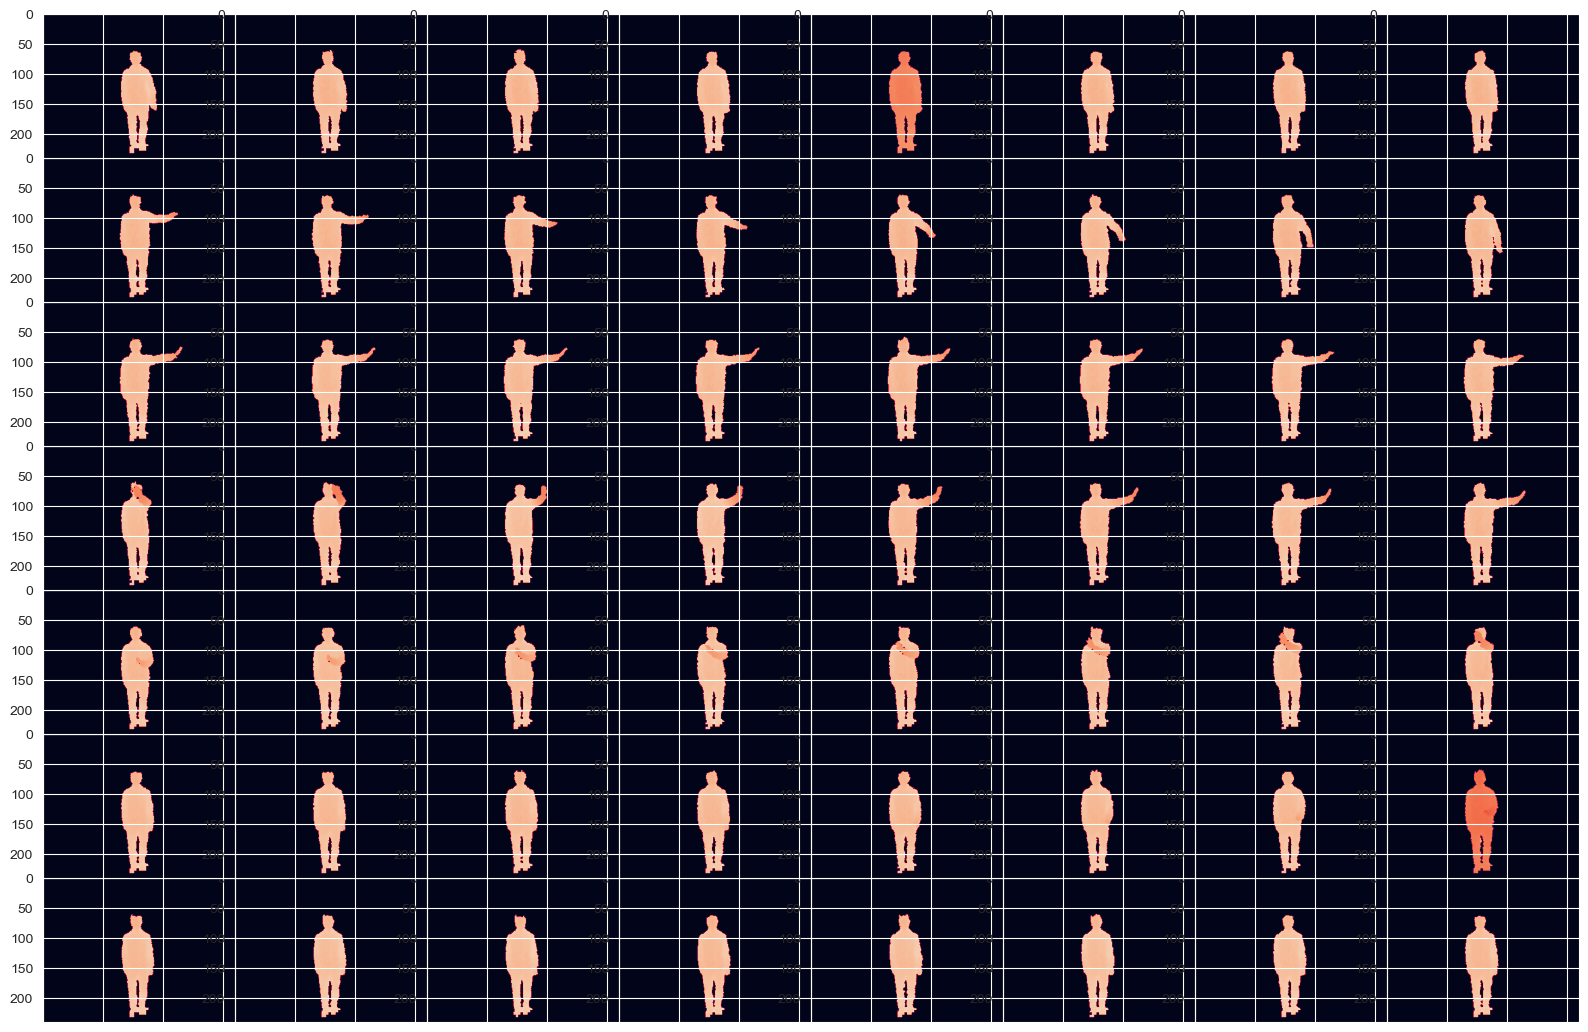

In [67]:
fig = plt.figure()

hw=0.3
index = 0;

# Calculate number of rows
nrows = int(np.floor(numFrames/8))
for j in range(0,nrows):
    for i in range(0,8):
        ax = fig.add_axes([(i+1)*hw, (j+1)*hw, hw, hw],
                           xticklabels=[])

        ax.imshow(D[:,:,index])
        index +=1

### Write function to create feature matrix from all Depth frames

In [68]:
def average_frame(D):
    D1 = D.max(axis=2)
    D2 = D.min(axis=2)
    Dmid = D1+D2
    # Option 2 is averaging all values which is not so effective.
    #     Dmid = np.mean(D,axis=2)
    # Normalise between 0 - 1
    Dmid = Dmid/np.max(Dmid)
    return Dmid

### Create feature matrix and show

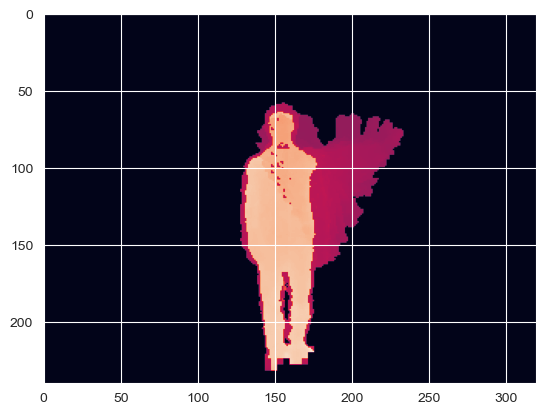

In [69]:
# Call feature extractor function
Dmid = average_frame(D)
%matplotlib inline
plt.imshow(Dmid)

### Visualise extracted features from each class

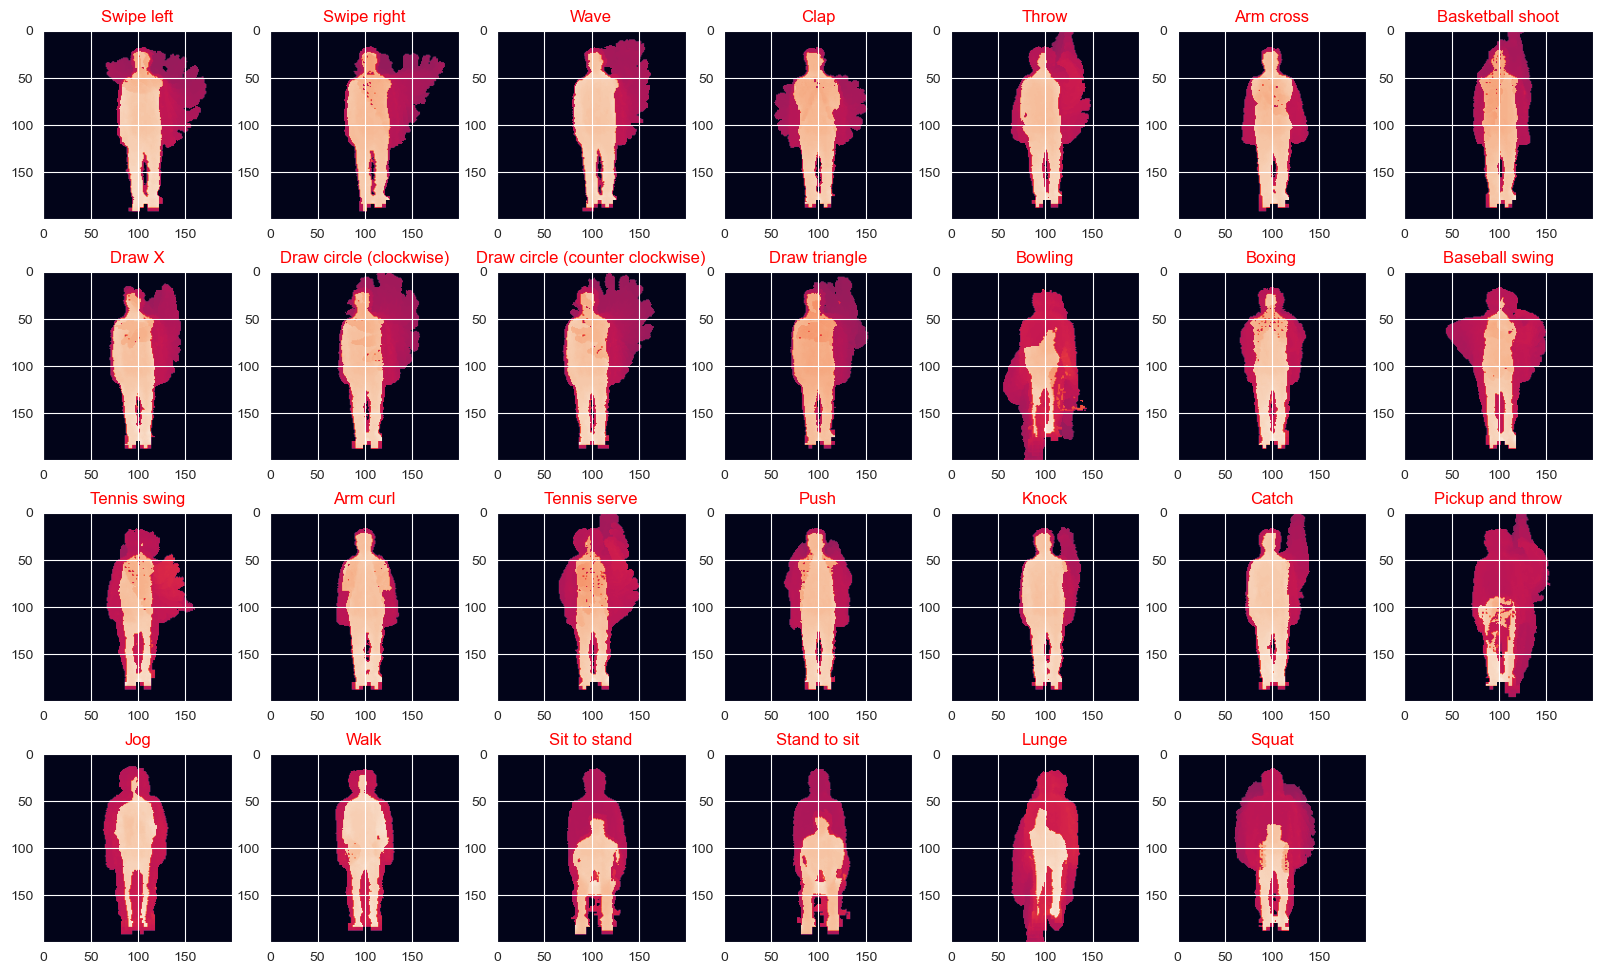

In [70]:
fig = plt.figure(figsize=(20,12))
# imstack = np.empty((200,200))
for aID  in range(1,28):
    Dpath = path.format('depth',aID,sID,tID,'depth')
    
    # read .MAT file for Dpath
    matD = scipy.io.loadmat(Dpath)

    # Obtain d_depth from matD dictionary.
    D = matD['d_depth']
    
    Dmid = average_frame(D)
    
    Dcrop = Dmid[40:,50:250]
 
    # imstack = np.dstack((imstack,Dcrop))

    plt.subplot(4,7, aID)
    plt.imshow(Dcrop)
    plt.title(action_names[aID-1],color = 'r')

### Extract features from all Depth files from dataset

In [71]:
%%time
fig = plt.figure(figsize=(15,15))
imstack = np.empty((200,200))
Dtarget = []
for aID  in range(1,28):
    for sID in range(1,9):
        for tID in range(1,5):
            Dpath = path.format('depth',aID,sID,tID,'depth')

            # read .MAT file for Dpath
            matD = scipy.io.loadmat(Dpath)

            # Obtain d_depth from matD dictionary.
            D = matD['d_depth']

            Dmid = average_frame(D)

            Dcrop = Dmid[40:,50:250]

            imstack = np.dstack((imstack,Dcrop))

            Dtarget.append(aID-1)
            
Dtarget = np.array(Dtarget)

CPU times: user 24 s, sys: 15.7 s, total: 39.7 s
Wall time: 40.7 s


<Figure size 1500x1500 with 0 Axes>

In [72]:
print('The shape of input Depth data:',imstack.shape)

The shape of input Depth data: (200, 200, 865)


### Reshape Depth data so that no of sample should be X values

In [73]:
imstack_norm=np.rollaxis(imstack,2,0)
imstack_norm.shape

(865, 200, 200)

In [74]:
# Remove first entry which is empty
imstack_norm = imstack_norm[1:,:,:]
imstack_norm.shape

(864, 200, 200)

Total number of freaures 864 (27 actions x 8 subjects x 4 samples)

## Skeleton Data

In [75]:
# read .MAT file for Skeleton
matS = scipy.io.loadmat(Spath)

In [76]:
# GEt skeleton data from dictionary
S = matS['d_skel']
# Get number of frames based on 3rd dimension of matrix
numFrames =S.shape[-1]

## Write some functions to display skeleton in 2D and 3D

In [77]:
def plot_im_skeleton(skeleton,ax):
    ''' This function defines the bone list and plot the skeleton from given cordinates'''

#     bone_list = [[0,1],[1,20],[20, 2], [2, 3], [2, 4], [4, 5], [5, 6], [6,7],[2, 8], [8,9], [9,10], [10, 11], 
#             [0,12],[12,13],[13, 14], [14, 15],[0,16],[16, 17], [17,18], [18, 19], [7, 21],[7,22],[11,23],[11,24]]#, [11, 22], [12, 13], ,[22,23],[23,24],[24,25]]
    bone_list = [[0,1],[1,2], [2, 3], [1, 4], [4, 5], [5, 6], [6,7],[1, 8], [8,9], [9,10], [10, 11], 
            [3,12],[12,13],[13, 14], [14, 15],[3,16],[16, 17], [17,18], [18, 19]]#, [11, 22], [12, 13], ,[22,23],[23,24],[24,25]]

    x = skeleton[:, 0]
    y = skeleton[:, 1]
    sc = ax.scatter(x, y, s=40,)
    for bone in bone_list:
        ax.plot([x[bone[0]], x[bone[1]]], [y[bone[0]], y[bone[1]]], 'r')

In [78]:
def plot_3D_skeleton(skeleton,ax):
    ''' This function defines the bone list and plot the skeleton from given cordinates'''

#     bone_list = [[0,1],[1,2], [2, 3], [2, 4], [4, 5], [5, 6], [6,7],[2, 8], [8,9], [9,10], [10, 11], 
#             [0,12],[12,13],[13, 14], [14, 15],[0,16],[16, 17], [17,18], [18, 19], [7, 21],[7,22],[11,23],[11,24]]#, [11, 22], [12, 13], ,[22,23],[23,24],[24,25]]
    bone_list = [[0,1],[1,2], [2, 3], [1, 4], [4, 5], [5, 6], [6,7],[1, 8], [8,9], [9,10], [10, 11], 
            [3,12],[12,13],[13, 14], [14, 15],[3,16],[16, 17], [17,18], [18, 19]]#, [11, 22], [12, 13], ,[22,23],[23,24],[24,25]]

    x = skeleton[:, 0]
    z = skeleton[:, 1]
    y = skeleton[:, 2]
    sc = ax.scatter(x, y, z, s=20)
    for bone in bone_list:
        ax.plot([x[bone[0]], x[bone[1]]], [y[bone[0]], y[bone[1]]], [z[bone[0]], z[bone[1]]], 'b')

## Write function to create feature image

In [79]:
def interp_vals(yin,numFrames):
    ''' This function interpolate Values of sensor according to number of frames'''
    xin = np.linspace(0, numFrames, len(yin))
    xnew = np.arange(0, numFrames)
    ynew = np.interp(xnew, xin, yin)
    return ynew

In [80]:
def norm_vals(x):
    '''Function to normalise any values between 0 to 1'''
    x = x-np.min(x)
    x = x/np.max(x)
    return x

In [81]:
def extract_features(S,flength,spoints):
    ''' This function takes x,y and z cordinate of specified skeleton joint and interpolate all values to given flength, 
    Finally normalise all values between 0-1 and return it as feature matrix'''
    feature_matrix = np.zeros((len(spoints)*3,flength))
    for i in range(len(spoints)):
        # Get X values for all frames
        sx = S[spoints[i],0,:]

        # Get Y values for all frames
        sy = S[spoints[i],1,:]

        # Get Z values for all frames
        sz = S[spoints[i],2,:]

        # Interpolate values
        sxi = interp_vals(sx,flength)
        syi = interp_vals(sy,flength)
        szi = interp_vals(sz,flength)

        # Normalise values
        sxi = norm_vals(sxi)
        syi = norm_vals(syi)
        szi = norm_vals(szi)
        
        # Store values into feature matrix
        feature_matrix[i*3,:] = sxi
        feature_matrix[i*3+1,:] = syi
        feature_matrix[i*3+2,:] = szi    
        
    return feature_matrix

### Plot skeleton of first frame

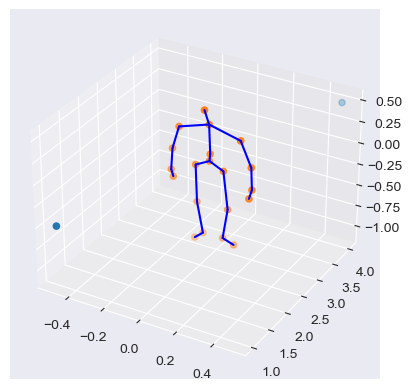

In [82]:
ax = plt.axes(projection='3d')
ax.scatter([-0.5, 0.5],[1,4],[-0.5,0.5],)
plot_3D_skeleton(S[:,:,0],ax)

## Visualise sequence of all frames

In [83]:
# Skeleton Values
%matplotlib notebook
#calling it a second time may prevent some graphics errors
%matplotlib notebook
%matplotlib notebook
for i in range(numFrames):
    skeleton = S[:,:,i] 
    ax = plt.axes(projection='3d')
    ax.scatter([-0.5, 0.5],[1,4],[-0.5,0.5],)
    plot_3D_skeleton(skeleton,ax)
    ax.mouse_init()
    plt.show()
    ax.set_title(['Frame: ',i])
    plt.pause(0.05)

<IPython.core.display.Javascript object>

### Plot 2D skeleton

<IPython.core.display.Javascript object>

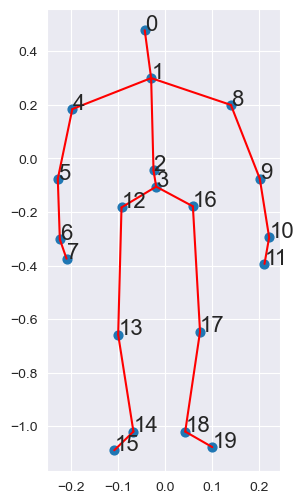

In [84]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(3,6))
plot_im_skeleton(S[:,:,0],ax)
for i in range(20):
    plt.text(S[i,0,0],S[i,1,0],i,fontsize = 16)

# Extract features of one sample and show

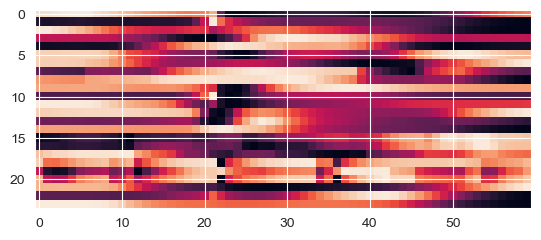

In [85]:
%matplotlib inline
# Define feature length
flength = 60
# Skeleton points to be considered for features
spoints = [1,11,7,8,4,15,19,3]

# Call function to extract feature matrix
fm = extract_features(S,flength,spoints)

# show image
plt.imshow(fm)

### Show extracted sample of each class

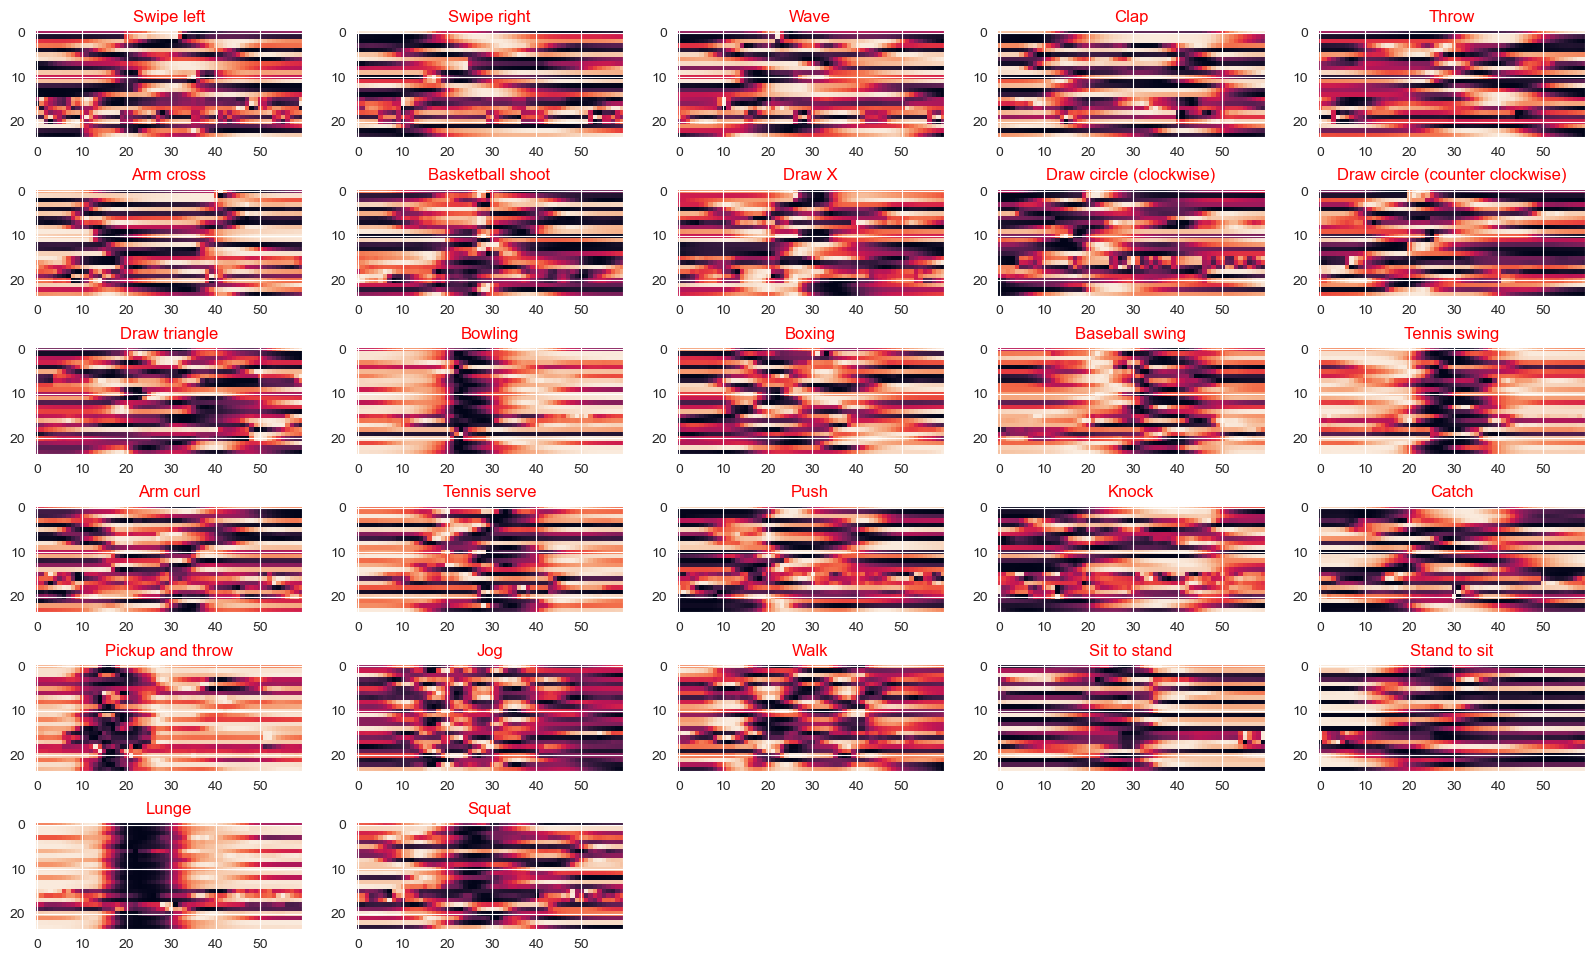

In [86]:
%matplotlib inline
# Define feature length
flength = 60
# Skeleton points to be considered for features
spoints = [1,11,7,8,4,15,19,3]

fig = plt.figure(figsize=(20,12))
# imstack = np.empty((200,200))
for aID  in range(1,28):
    Spath = path.format('Skeleton',aID,sID,tID,'skeleton')
    
    # read .MAT file for Dpath
    matS = scipy.io.loadmat(Spath)

    # Obtain d_depth from matD dictionary.
    S = matS['d_skel']
    
    fm = extract_features(S,flength,spoints)
    
    plt.subplot(6,5, aID)
    plt.imshow(fm)
    plt.title(action_names[aID-1],color='r')

### Extract features for all dataset sample of skeleton

In [87]:
%%time
# Define feature length
flength = 60
# Skeleton points to be considered for features
spoints = [1,11,7,8,4,15,19,3]

Sstack = np.zeros((len(spoints)*3,flength))
Starget = []
for aID  in range(1,28):
    for sID in range(1,9):
        for tID in range(1,5):
            Spath = path.format('skeleton',aID,sID,tID,'skeleton')
    
            # read .MAT file for Dpath
            matS = scipy.io.loadmat(Spath)

            # Obtain d_depth from matD dictionary.
            S = matS['d_skel']

            fm = extract_features(S,flength,spoints)
            
            Sstack = np.dstack((Sstack,fm))

            Starget.append(aID-1)
            
Starget = np.array(Starget)

CPU times: user 533 ms, sys: 165 ms, total: 698 ms
Wall time: 745 ms


### Reshape Skeleton data so that no of sample should be X values

In [88]:
Sstack_norm=np.rollaxis(Sstack,2,0)
Sstack_norm.shape

(865, 24, 60)

### Delete first empty sample

In [89]:
Sstack_norm = Sstack_norm[1:,:,:]

# Inertial Data 

In [90]:
# Inertial
mat_inn = scipy.io.loadmat(Ipath)

In [91]:
# Get sensor value
d_iner = mat_inn['d_iner']

 ### Write function to interpolate matrix

In [92]:
def interpolate_cols(d_iner,interpval=60):
    # Intialise empty matrix
    imat = np.zeros((interpval,d_iner.shape[1]))
    for i in range(d_iner.shape[1]):
        val = d_iner[:,i]
        ival = interp_vals(val,interpval)
        
        # normalise values between 0-1
        ival = norm_vals(ival)
        
        # Store values back to matrix
        imat[:,i] = ival
    return imat

In [93]:
imat = interpolate_cols(d_iner,60)
imat.shape

(60, 6)

## Plot one sample

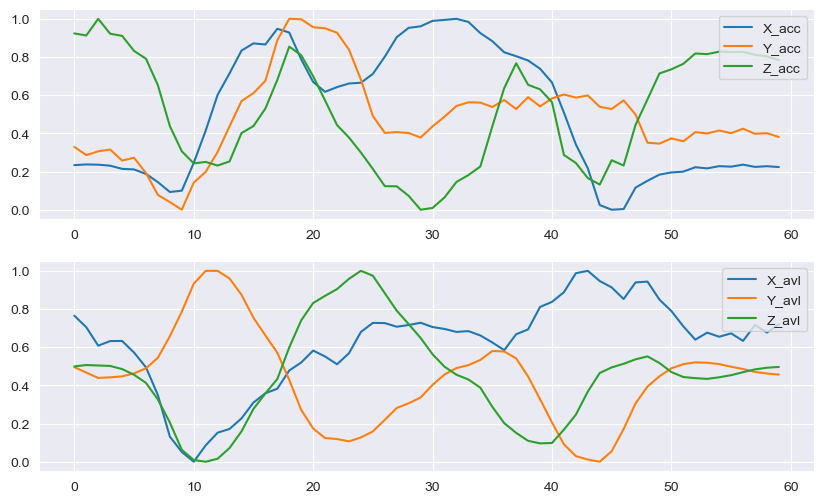

In [94]:
%matplotlib inline
fig, ax = plt.subplots(nrows=2,ncols=1,figsize=(10,6))
ax[0].plot(imat[:,0:3])
ax[0].legend(labels=['X_acc','Y_acc','Z_acc'],loc='upper right')
ax[0].grid(True)
ax[1].plot(imat[:,3:])
ax[1].legend(labels=['X_avl','Y_avl','Z_avl'],loc='upper right')
ax[1].grid(True)
# plt.legend()

# Extract features from all Sensor data

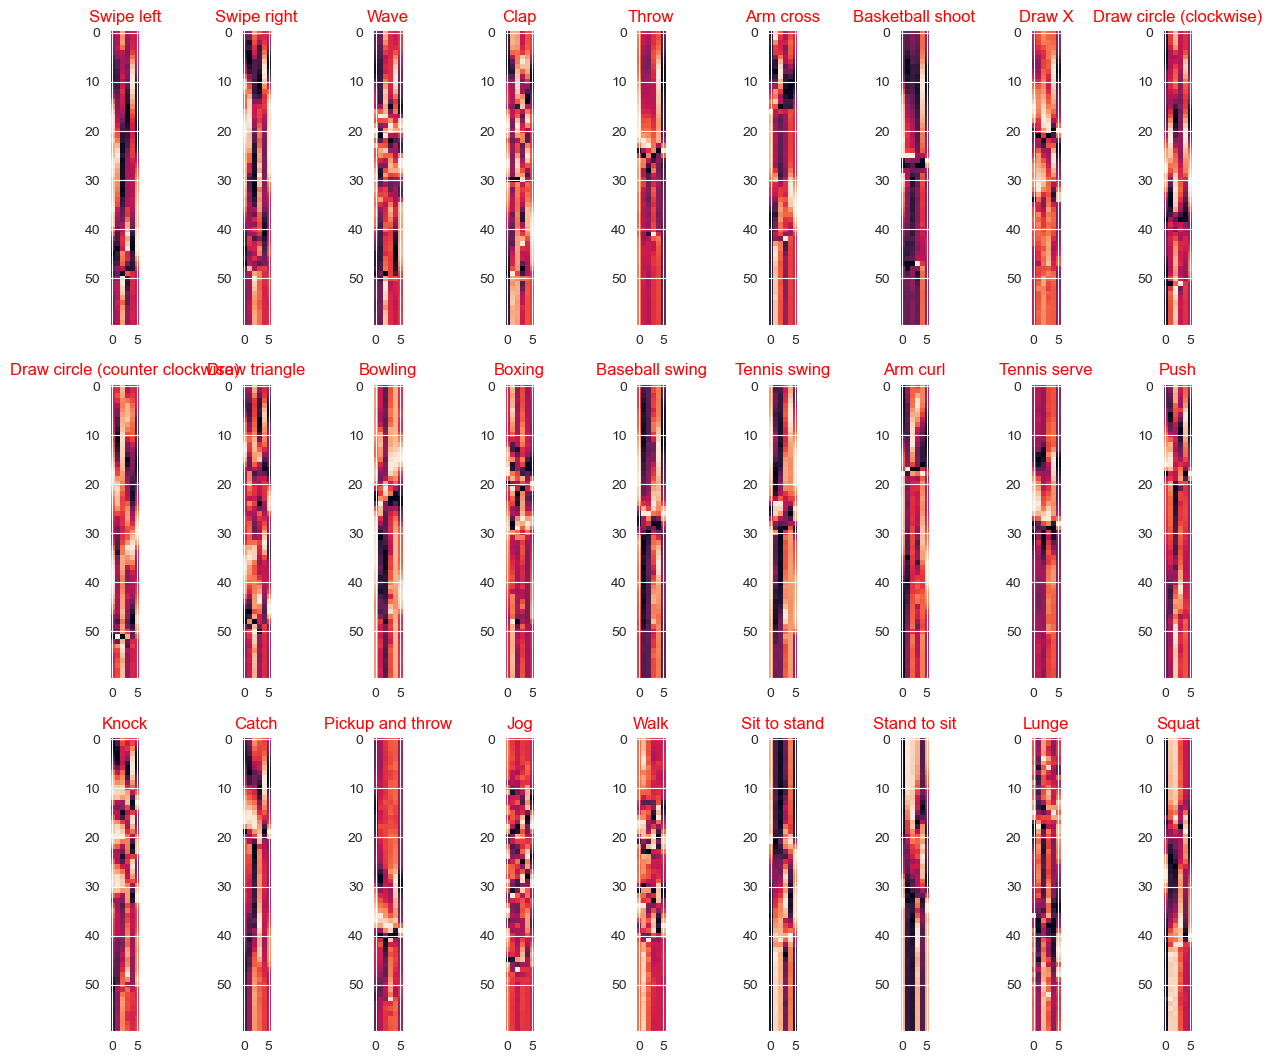

In [95]:
%matplotlib inline
# Define feature length
flength = 60

fig = plt.figure(figsize=(15,13))
# imstack = np.empty((200,200))
for aID  in range(1,28):
    Ipath = path.format('inertial',aID,sID,tID,'inertial')

    # Inertial
    mat_inn = scipy.io.loadmat(Ipath)

    # Get sensor value
    d_iner = mat_inn['d_iner']

    # interpolate and normalise all columns
    fi = interpolate_cols(d_iner,flength)
    
    plt.subplot(3,9, aID)
    plt.imshow(fi)
    plt.title(action_names[aID-1],color='r')

In [96]:
%%time
# Define feature length
flength = 60

Istack = np.zeros((flength,6))
Itarget = []
for aID  in range(1,28):
    for sID in range(1,9):
        for tID in range(1,5):
            Ipath = path.format('inertial',aID,sID,tID,'inertial')
            
            # Inertial
            mat_inn = scipy.io.loadmat(Ipath)

            # Get sensor value
            d_iner = mat_inn['d_iner']

            # interpolate and normalise all columns
            fi = interpolate_cols(d_iner,flength)
            
            Istack = np.dstack((Istack,fi))

            Itarget.append(aID-1)
            
# Delete first entry
Istack = Istack[:,:,1:]
Itarget = np.array(Itarget)

CPU times: user 168 ms, sys: 53.2 ms, total: 221 ms
Wall time: 251 ms


In [97]:
Istack.shape

(60, 6, 864)

### Reshape matrix as per Deep learning standard

In [98]:
Istack_norm=np.rollaxis(Istack,2,0)
Istack_norm.shape

(864, 60, 6)

In [99]:
Sstack_norm.shape

(864, 24, 60)

# -------------- Modelling ----------------------------

### Write function to calculate accuracy, recall and precision

In [100]:
def cal_results(Dy_test,Fy_pred):
    CM = confusion_matrix(Dy_test,Fy_pred)
    accuracy = np.sum(np.diag(CM))/np.sum(CM)
    recall = np.mean(np.diag(CM) / np.sum(CM, axis = 1))
    precision = np.mean(np.diag(CM) / np.sum(CM, axis = 0))
    return accuracy,recall,precision

In [101]:
# Define test size
Tsize= 0.66
DX_train, DX_test, Dy_train, Dy_test = train_test_split(imstack_norm,Dtarget, test_size=Tsize,
                                                    random_state=42,stratify=Dtarget)
SX_train, SX_test, Sy_train, Sy_test = train_test_split(Sstack_norm,Starget, test_size=Tsize,
                                                    random_state=42,stratify=Starget)
IX_train, IX_test, Iy_train, Iy_test = train_test_split(Istack_norm,Itarget, test_size=Tsize,
                                                    random_state=42,stratify=Itarget)

In [102]:
def evaluate_model_1(X_train,X_test,y_train,y_test):
    '''This function train model 1 based on X_train and y_train'''
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=X_train.shape[1:]),
        keras.layers.Dense(128,activation=tf.nn.relu),
        keras.layers.Dense(128,activation=tf.nn.relu),
        keras.layers.Dense(27,activation=tf.nn.softmax)
    ])
    model.compile(optimizer = tf.keras.optimizers.legacy.Adam(),
                 loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy'])
    # model.fit(imstack_norm,np.array(target),epochs=10)
    model.fit(X_train,y_train,epochs=20)
    return model

In [103]:
def evaluate_model_2(X_train,X_test,y_train,y_test):
    '''This function train model 1 based on X_train and y_train'''
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=X_train.shape[1:]),
        keras.layers.Dense(128,activation=tf.nn.conv2d),
        keras.layers.Dense(128,activation=tf.nn.relu),
        keras.layers.Dense(27,activation=tf.nn.max_pool)
    ])
    model.compile(optimizer = tf.keras.optimizers.legacy.Adam(),
                 loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy'])
    # model.fit(imstack_norm,np.array(target),epochs=10)
    model.fit(X_train,y_train,epochs=20)
    return model

## Calculate baseline

In [104]:
y_pred = np.ones(len(Dtarget))
CM = confusion_matrix(Dtarget,y_pred)
accuracyb = np.sum(np.diag(CM))/np.sum(CM)
recallb = np.mean(np.diag(CM) / np.sum(CM, axis = 1))
precisionb = np.mean(np.diag(CM) / np.sum(CM, axis = 0))
print('Baseline Accuracy', accuracyb)
print('Baseline Recall', recallb)
print('Baseline Precision', precisionb)

Baseline Accuracy 0.037037037037037035
Baseline Recall 0.037037037037037035
Baseline Precision nan


/var/folders/dw/hly7xzz559324v4_5hrbs0nr0000gp/T/ipykernel_3791/2970586325.py:5: RuntimeWarning: invalid value encountered in divide
  precisionb = np.mean(np.diag(CM) / np.sum(CM, axis = 0))


In [105]:
Dmodel = evaluate_model_1(DX_train,DX_test,Dy_train,Dy_test)
Smodel = evaluate_model_1(SX_train,SX_test,Sy_train,Sy_test)
Imodel = evaluate_model_1(IX_train,IX_test,Iy_train,Iy_test)

Epoch 1/20
10/10 [==============================] - 0s 16ms/step - loss: 21.2590 - accuracy: 0.0546
Epoch 2/20
10/10 [==============================] - 0s 12ms/step - loss: 14.7233 - accuracy: 0.1092
Epoch 3/20
10/10 [==============================] - 0s 13ms/step - loss: 11.5682 - accuracy: 0.1195
Epoch 4/20
10/10 [==============================] - 0s 13ms/step - loss: 6.9855 - accuracy: 0.1502
Epoch 5/20
10/10 [==============================] - 0s 13ms/step - loss: 5.1898 - accuracy: 0.2116
Epoch 6/20
10/10 [==============================] - 0s 12ms/step - loss: 5.0927 - accuracy: 0.2116
Epoch 7/20
10/10 [==============================] - 0s 13ms/step - loss: 3.9217 - accuracy: 0.2321
Epoch 8/20
10/10 [==============================] - 0s 12ms/step - loss: 3.6968 - accuracy: 0.3242
Epoch 9/20
10/10 [==============================] - 0s 11ms/step - loss: 3.1258 - accuracy: 0.3857
Epoch 10/20
10/10 [==============================] - 0s 12ms/step - loss: 3.4254 - accuracy: 0.3276
Epoch 

In [106]:
def test_model(y_test,ypred):
    # Find position of maximum value to get predicted output
    y_pred = [np.argmax(i) for i in ypred]
    CM = confusion_matrix(y_test,y_pred)
    accuracy = np.sum(np.diag(CM))/np.sum(CM)
    recall = np.mean(np.diag(CM) / np.sum(CM, axis = 1))
    precision = np.mean(np.diag(CM) / np.sum(CM, axis = 0))
    return accuracy,recall,precision,CM

In [107]:
# Evaluate all three models
Dypred = Dmodel.predict(DX_test)
Sypred = Smodel.predict(SX_test)
Iypred = Imodel.predict(IX_test)
Fypred = (Dypred+Sypred+Iypred)/3

18/18 [==============================] - 0s 1ms/step


In [108]:
Dacc,Drec,Dpre,DCM = test_model(Dy_test,Dypred)
Sacc,Srec,Spre,SCM = test_model(Sy_test,Sypred)
Iacc,Irec,Ipre,ICM = test_model(Iy_test,Iypred)
Facc,Frec,Fpre,FCM = test_model(Dy_test,Fypred)

/var/folders/dw/hly7xzz559324v4_5hrbs0nr0000gp/T/ipykernel_3791/373889244.py:7: RuntimeWarning: invalid value encountered in divide
  precision = np.mean(np.diag(CM) / np.sum(CM, axis = 0))


In [109]:
print(Dacc,Sacc,Iacc,Facc)

0.35901926444833626 0.7513134851138353 0.6637478108581436 0.7530647985989493


<Axes: >

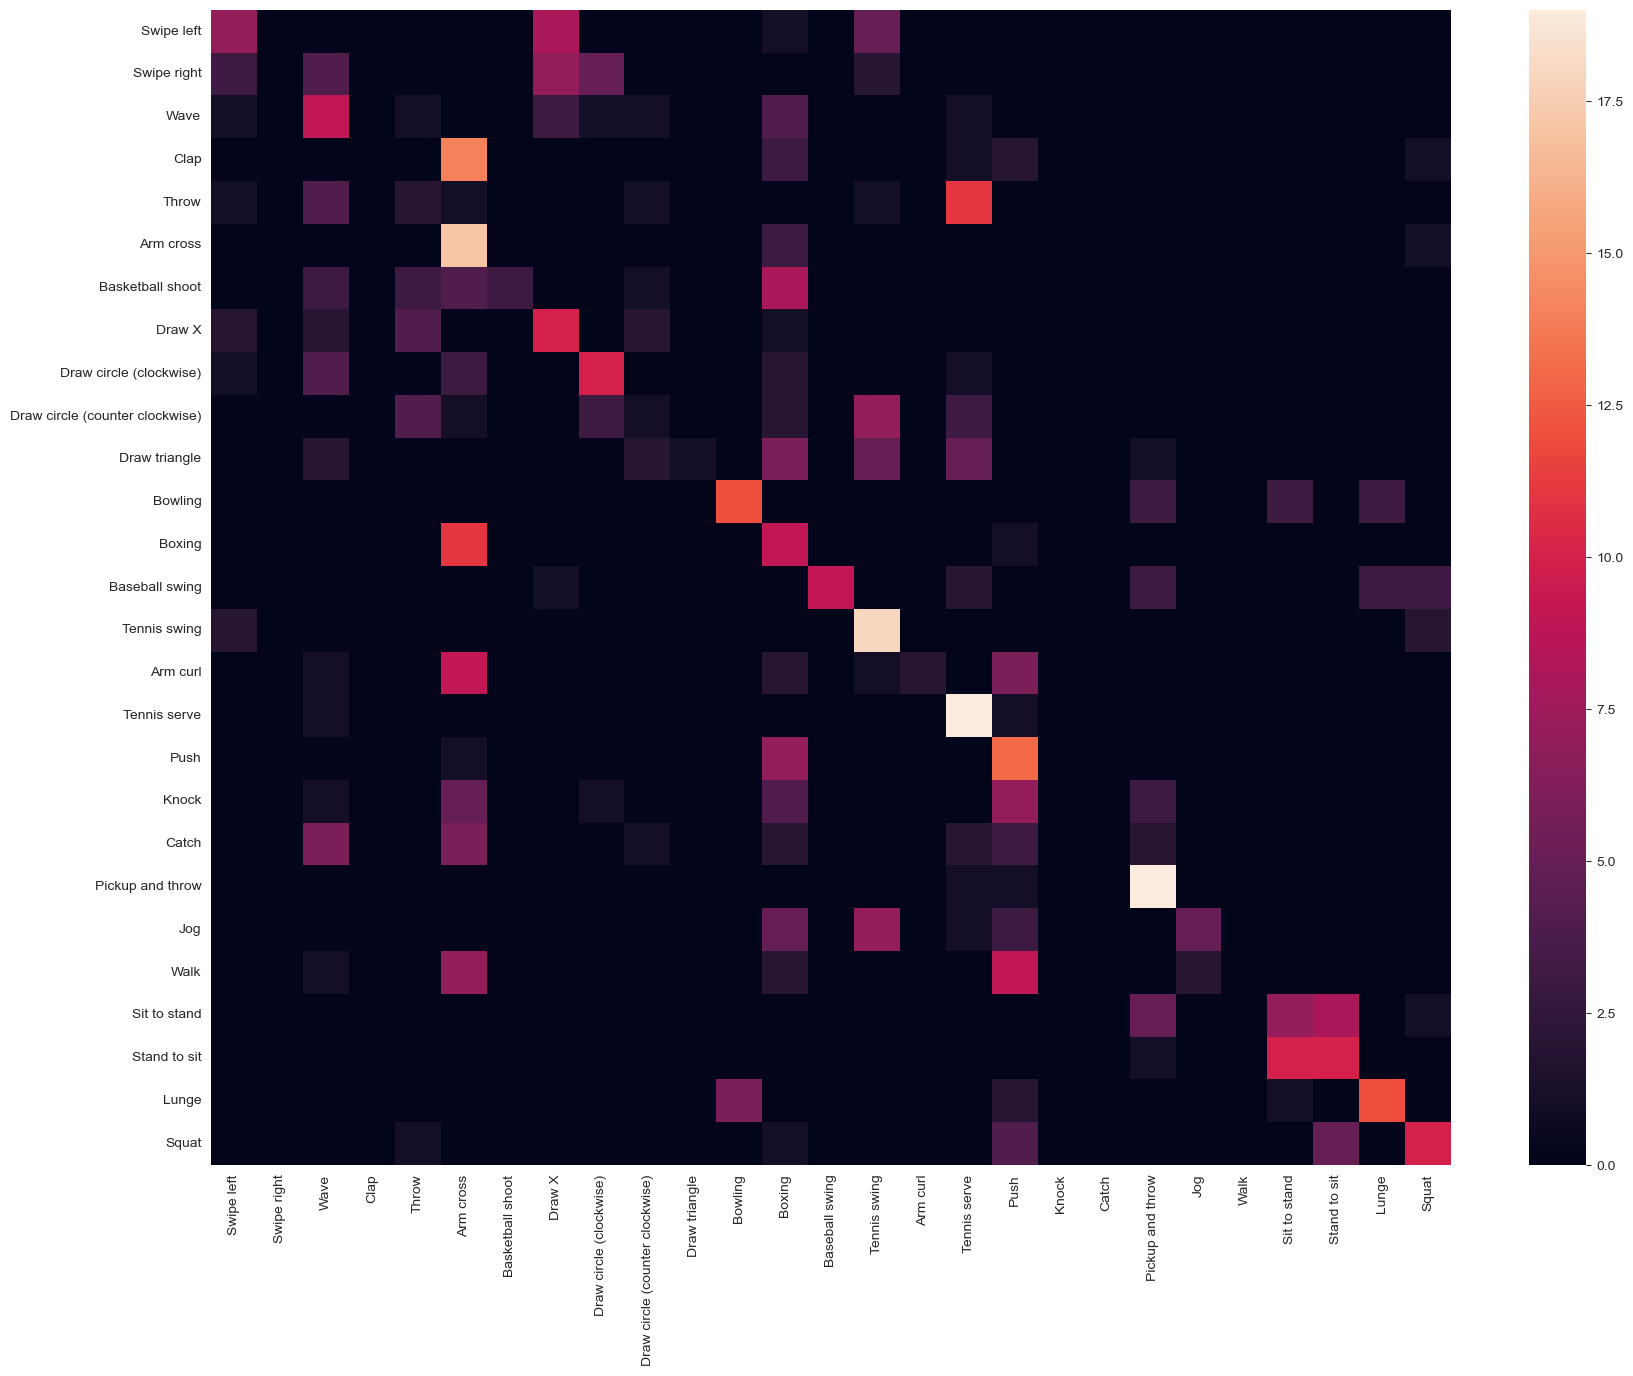

In [110]:
DCMdf = pd.DataFrame(DCM,columns=action_names,index=action_names)
plt.figure(figsize = (20,15))
sns.heatmap(DCMdf)

<Axes: >

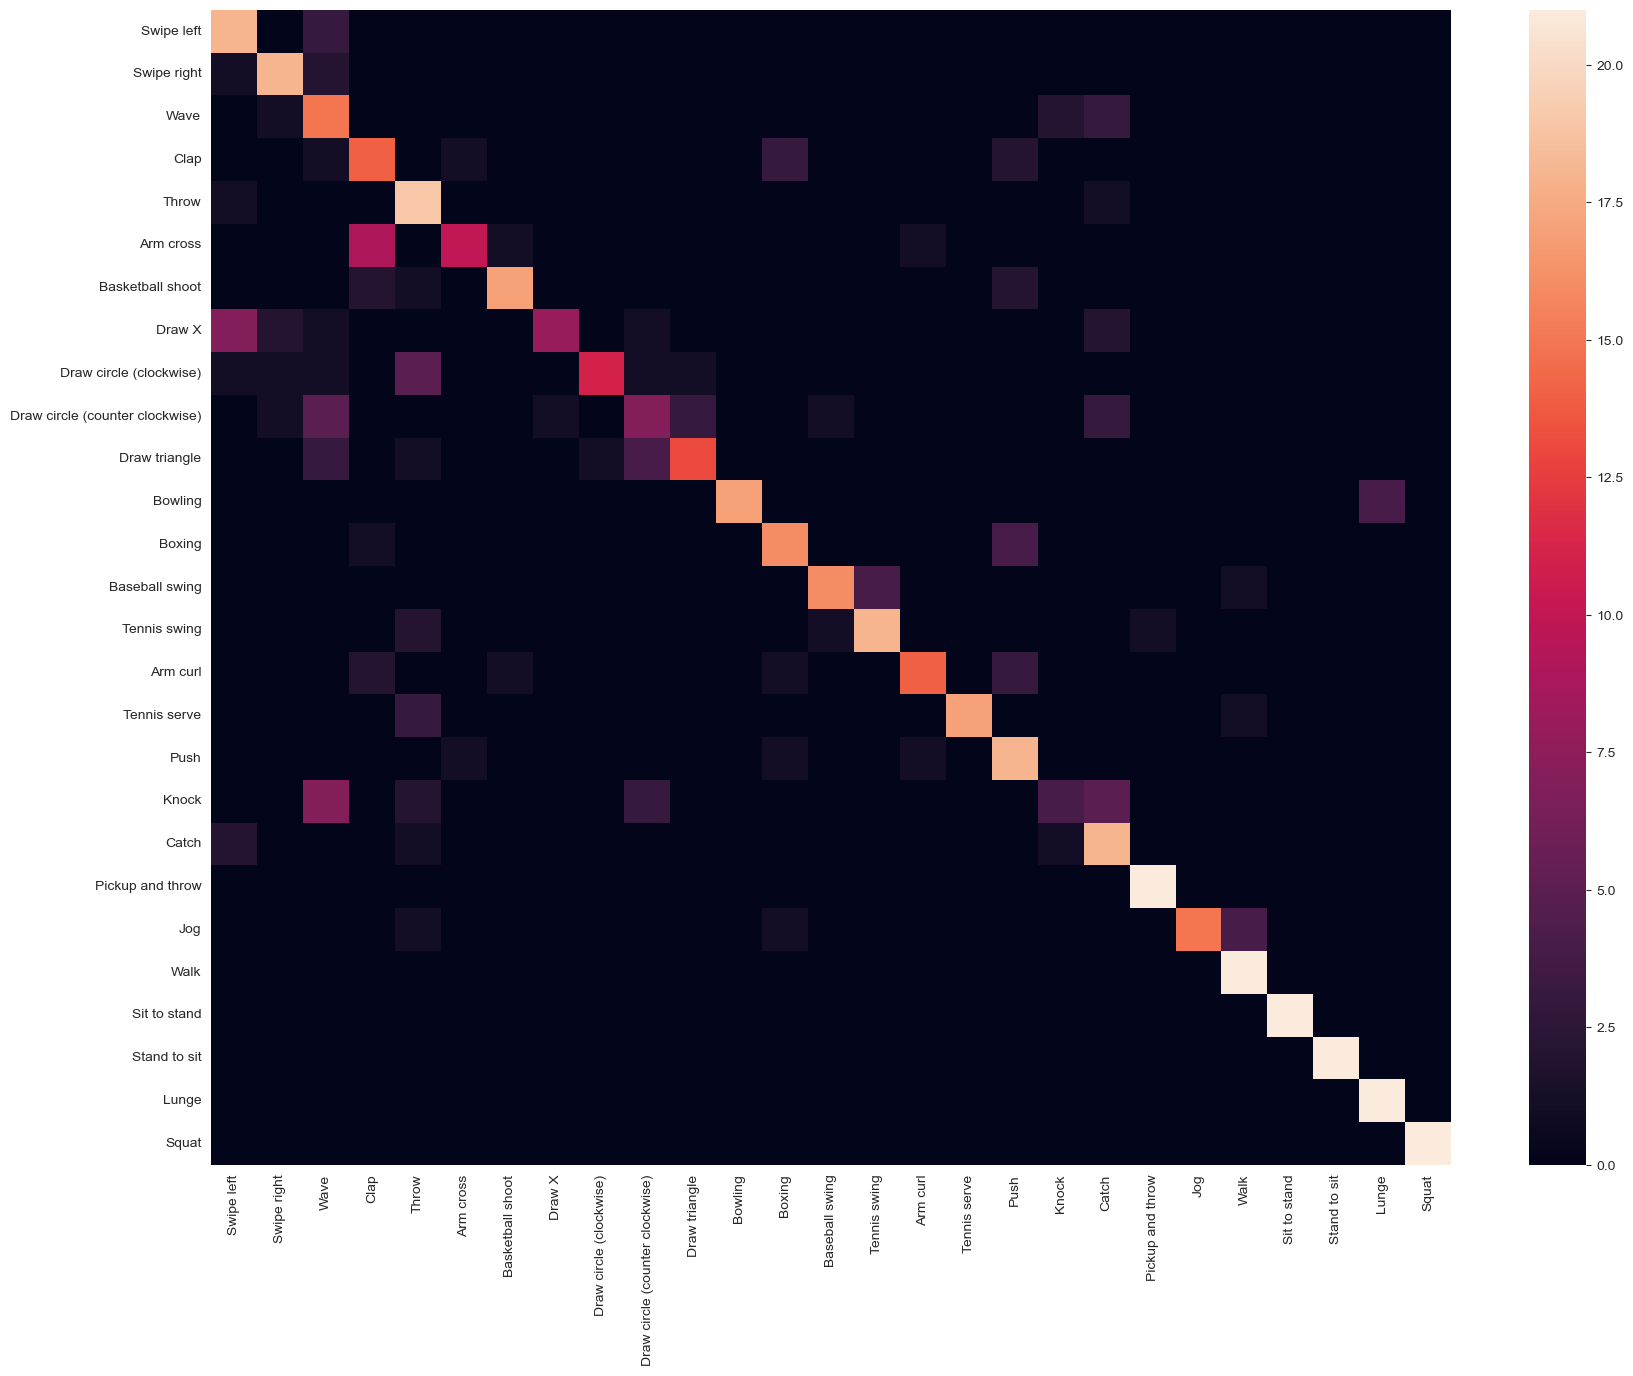

In [111]:
SCMdf = pd.DataFrame(SCM,columns=action_names,index=action_names)
plt.figure(figsize = (20,15))
sns.heatmap(SCMdf)

<Axes: >

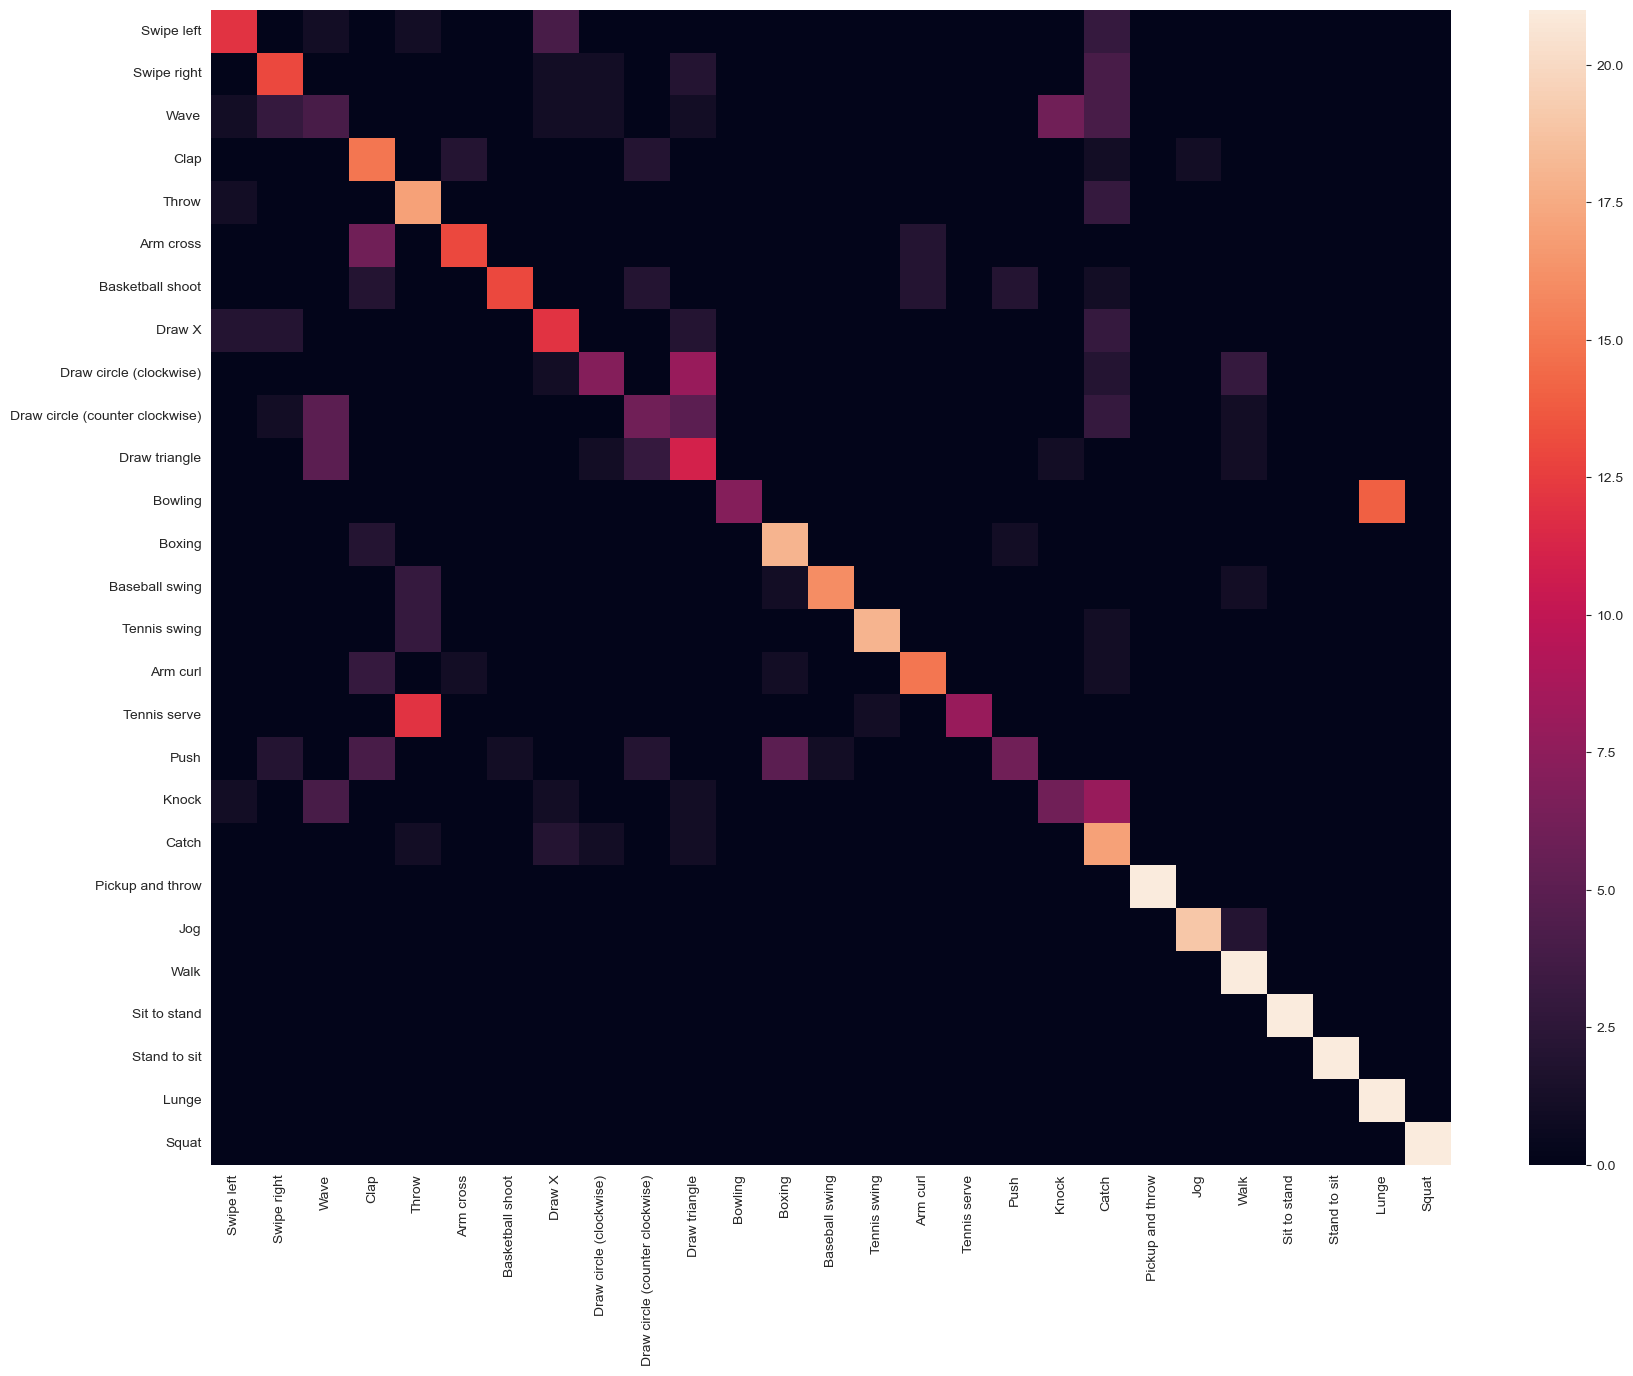

In [112]:
ICMdf = pd.DataFrame(ICM,columns=action_names,index=action_names)
plt.figure(figsize = (20,15))
sns.heatmap(ICMdf)

<Axes: >

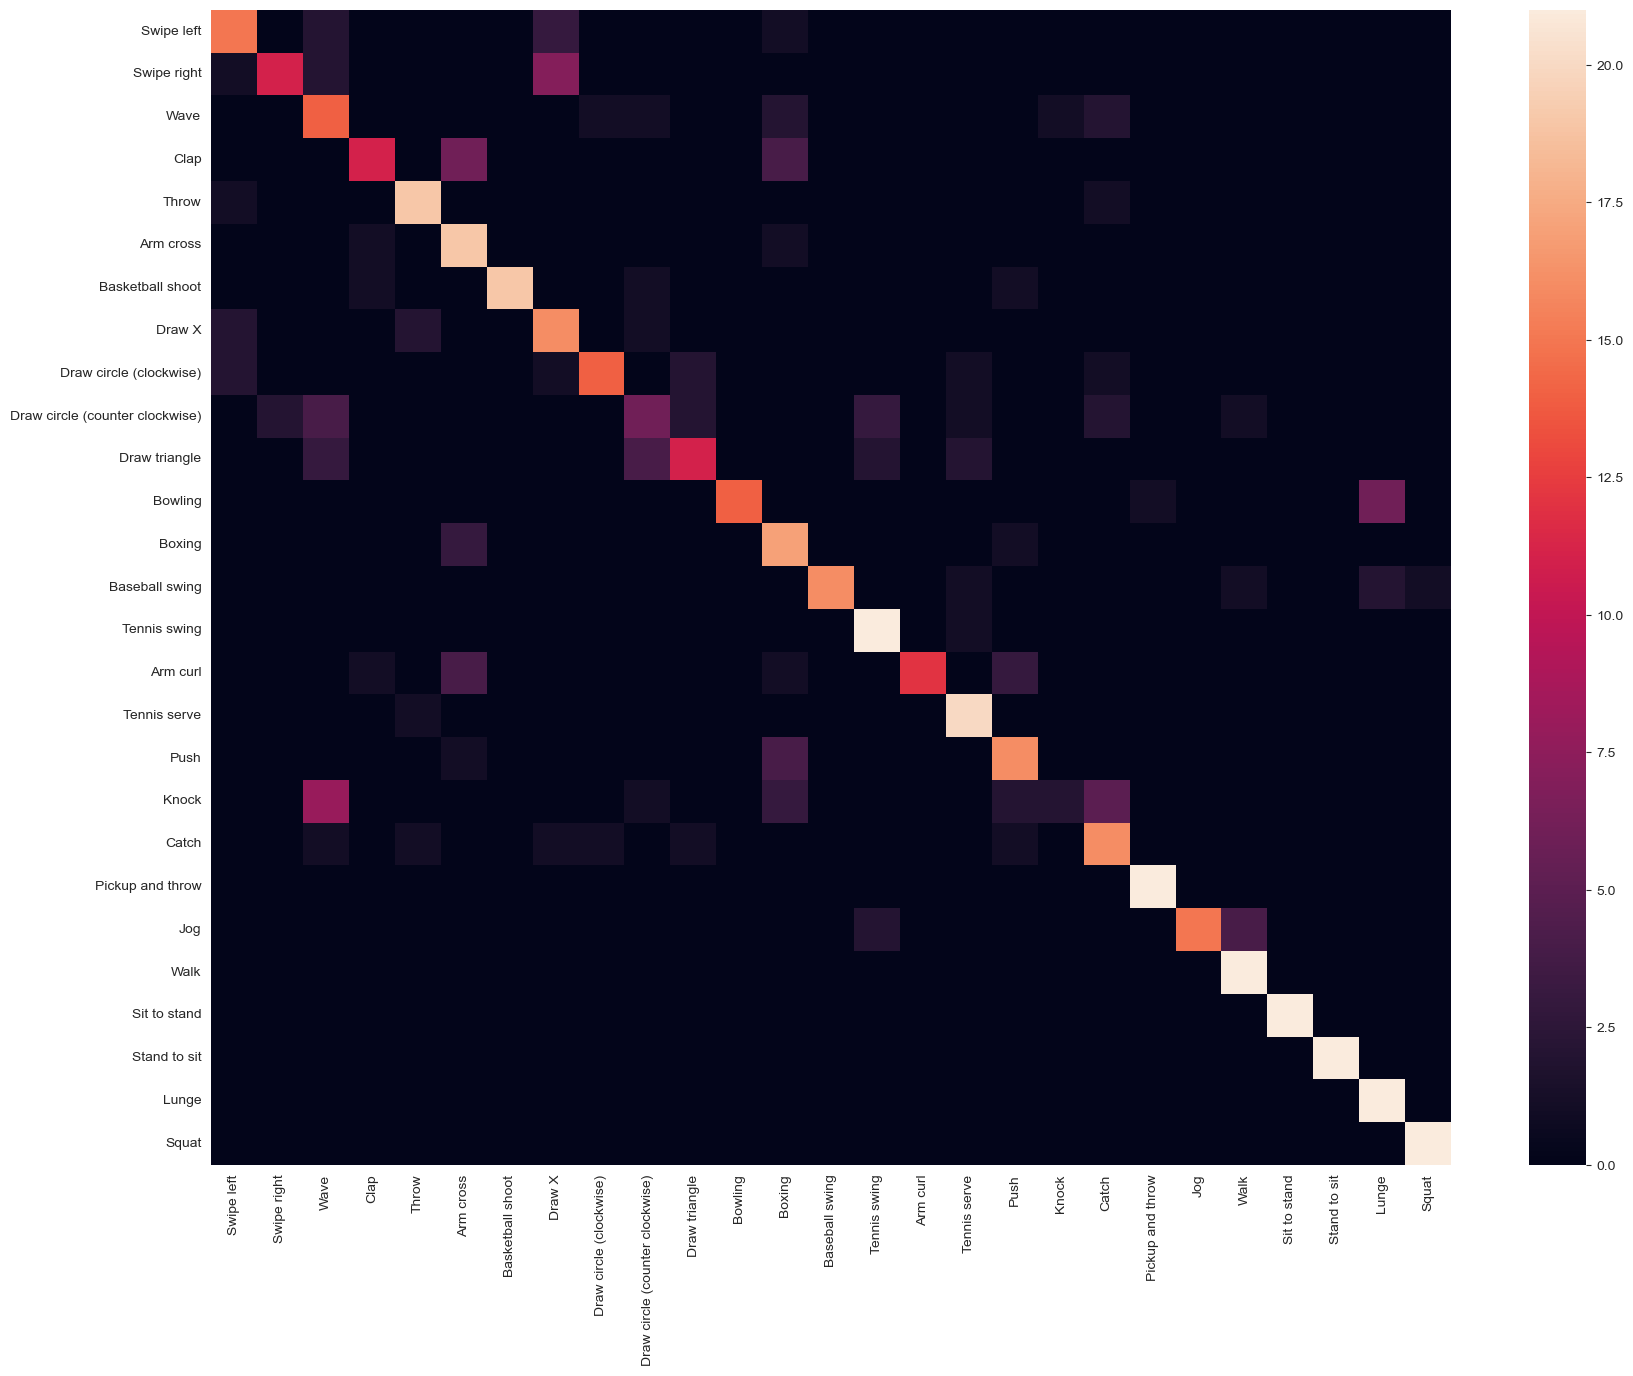

In [113]:
FCMdf = pd.DataFrame(FCM,columns=action_names,index=action_names)
plt.figure(figsize = (20,15))
sns.heatmap(FCMdf)

In [114]:
print(Dacc,Drec,Dpre,Sacc,Srec,Spre,Iacc,Irec,Ipre,Facc,Frec,Fpre)

0.35901926444833626 0.35978835978835977 nan 0.7513134851138353 0.7513227513227513 0.7849007106381232 0.6637478108581436 0.6637004970338304 0.7138921865084851 0.7530647985989493 0.753006253006253 0.7812436263898849


In [115]:

# %% time
accmat = np.zeros((4,4))
recmat = np.zeros((4,4))
premat = np.zeros((4,4))

index = 0
for Tsize in np.arange(0.2,0.8,0.2):

    DX_train, DX_test, Dy_train, Dy_test = train_test_split(imstack_norm,Dtarget, test_size=Tsize,
                                                        random_state=42,stratify=Dtarget)
    SX_train, SX_test, Sy_train, Sy_test = train_test_split(Sstack_norm,Starget, test_size=Tsize,
                                                        random_state=42,stratify=Starget)
    IX_train, IX_test, Iy_train, Iy_test = train_test_split(Sstack_norm,Itarget, test_size=Tsize,
                                                        random_state=42,stratify=Itarget)

    # Train models
    Dmodel= evaluate_model_1(DX_train,DX_test,Dy_train,Dy_test)
    Smodel = evaluate_model_1(SX_train,SX_test,Sy_train,Sy_test)
    Imodel = evaluate_model_1(IX_train,IX_test,Iy_train,Iy_test)

    # Evaluate all three models
    Dypred = Dmodel.predict(DX_test)
    Sypred = Smodel.predict(SX_test)
    Iypred = Imodel.predict(IX_test)

    # Create fusion result
    Fypred = (Dypred+Sypred+Iypred)/3

    Dacc,Drec,Dpre,DCM = test_model(Dy_test,Dypred)
    Sacc,Srec,Spre,SCM = test_model(Sy_test,Sypred)
    Iacc,Irec,Ipre,ICM = test_model(Iy_test,Iypred)
    Facc,Frec,Fpre,FCM = test_model(Dy_test,Fypred)
    
    accmat[index,:] = [Dacc,Sacc,Iacc,Facc]
    recmat[index,:] = [Drec,Srec,Irec,Frec]
    premat[index,:] = [Dpre,Spre,Ipre,Fpre]
    index+=1
    

Epoch 1/20
22/22 [==============================] - 0s 15ms/step - loss: 13.8886 - accuracy: 0.0593
Epoch 2/20
22/22 [==============================] - 0s 12ms/step - loss: 6.6027 - accuracy: 0.1650
Epoch 3/20
22/22 [==============================] - 0s 13ms/step - loss: 4.4634 - accuracy: 0.2214
Epoch 4/20
22/22 [==============================] - 0s 13ms/step - loss: 3.7151 - accuracy: 0.2808
Epoch 5/20
22/22 [==============================] - 0s 13ms/step - loss: 3.3460 - accuracy: 0.2836
Epoch 6/20
22/22 [==============================] - 0s 12ms/step - loss: 3.2506 - accuracy: 0.2865
Epoch 7/20
22/22 [==============================] - 0s 12ms/step - loss: 3.2604 - accuracy: 0.3111
Epoch 8/20
22/22 [==============================] - 0s 13ms/step - loss: 3.1796 - accuracy: 0.3430
Epoch 9/20
22/22 [==============================] - 0s 13ms/step - loss: 2.6280 - accuracy: 0.3878
Epoch 10/20
22/22 [==============================] - 0s 11ms/step - loss: 2.5251 - accuracy: 0.4038
Epoch 11

/var/folders/dw/hly7xzz559324v4_5hrbs0nr0000gp/T/ipykernel_3791/373889244.py:7: RuntimeWarning: invalid value encountered in divide
  precision = np.mean(np.diag(CM) / np.sum(CM, axis = 0))


Epoch 1/20
17/17 [==============================] - 0s 15ms/step - loss: 15.8317 - accuracy: 0.0695
Epoch 2/20
17/17 [==============================] - 0s 12ms/step - loss: 8.5329 - accuracy: 0.1216
Epoch 3/20
17/17 [==============================] - 0s 13ms/step - loss: 4.5746 - accuracy: 0.2355
Epoch 4/20
17/17 [==============================] - 0s 13ms/step - loss: 3.9599 - accuracy: 0.2432
Epoch 5/20
17/17 [==============================] - 0s 12ms/step - loss: 4.0162 - accuracy: 0.2703
Epoch 6/20
17/17 [==============================] - 0s 11ms/step - loss: 3.6173 - accuracy: 0.3108
Epoch 7/20
17/17 [==============================] - 0s 11ms/step - loss: 3.5642 - accuracy: 0.3263
Epoch 8/20
17/17 [==============================] - 0s 13ms/step - loss: 3.1395 - accuracy: 0.3552
Epoch 9/20
17/17 [==============================] - 0s 12ms/step - loss: 2.5680 - accuracy: 0.4344
Epoch 10/20
17/17 [==============================] - 0s 12ms/step - loss: 2.7616 - accuracy: 0.4402
Epoch 11

/var/folders/dw/hly7xzz559324v4_5hrbs0nr0000gp/T/ipykernel_3791/373889244.py:7: RuntimeWarning: invalid value encountered in divide
  precision = np.mean(np.diag(CM) / np.sum(CM, axis = 0))


Epoch 1/20
6/6 [==============================] - 0s 19ms/step - loss: 13.4958 - accuracy: 0.0407
Epoch 2/20
6/6 [==============================] - 0s 15ms/step - loss: 14.2670 - accuracy: 0.0930
Epoch 3/20
6/6 [==============================] - 0s 13ms/step - loss: 10.7376 - accuracy: 0.1279
Epoch 4/20
6/6 [==============================] - 0s 13ms/step - loss: 8.4382 - accuracy: 0.1570
Epoch 5/20
6/6 [==============================] - 0s 13ms/step - loss: 5.9975 - accuracy: 0.2384
Epoch 6/20
6/6 [==============================] - 0s 12ms/step - loss: 5.9205 - accuracy: 0.2616
Epoch 7/20
6/6 [==============================] - 0s 11ms/step - loss: 4.7082 - accuracy: 0.2849
Epoch 8/20
6/6 [==============================] - 0s 10ms/step - loss: 4.1034 - accuracy: 0.3081
Epoch 9/20
6/6 [==============================] - 0s 11ms/step - loss: 3.9114 - accuracy: 0.3372
Epoch 10/20
6/6 [==============================] - 0s 12ms/step - loss: 3.2738 - accuracy: 0.3779
Epoch 11/20
6/6 [=========

/var/folders/dw/hly7xzz559324v4_5hrbs0nr0000gp/T/ipykernel_3791/373889244.py:7: RuntimeWarning: invalid value encountered in divide
  precision = np.mean(np.diag(CM) / np.sum(CM, axis = 0))


In [116]:
print(accmat)

[[0.48554913 0.83236994 0.83236994 0.86127168]
 [0.4566474  0.82369942 0.81791908 0.86416185]
 [0.38921002 0.73410405 0.72254335 0.77071291]
 [0.26011561 0.63150289 0.6199422  0.6416185 ]]


In [117]:
print(recmat)

[[0.48941799 0.83333333 0.83333333 0.86243386]
 [0.45584046 0.82241216 0.81623932 0.86301045]
 [0.38849903 0.73440546 0.72202729 0.77017544]
 [0.2608547  0.63293447 0.6202849  0.6425641 ]]


In [118]:
print(premat)

[[       nan 0.85175432 0.85392416 0.90495297]
 [0.68642478 0.8314315  0.82906332 0.87552786]
 [       nan 0.81038397 0.75893175 0.81209775]
 [       nan 0.67233844 0.6765117  0.71250656]]


In [119]:
accdf = pd.DataFrame(accmat,columns=['Depth','Skeleton','Sensor','Fusion'],index=['0.2','0.4','0.6','0.8'])
accdf

,Depth,Skeleton,Sensor,Fusion
0.2,0.485549,0.832370,0.832370,0.861272
0.4,0.456647,0.823699,0.817919,0.864162
0.6,0.389210,0.734104,0.722543,0.770713
0.8,0.260116,0.631503,0.619942,0.641618


Text(0.5, 1.0, 'Accuracy Comparison')

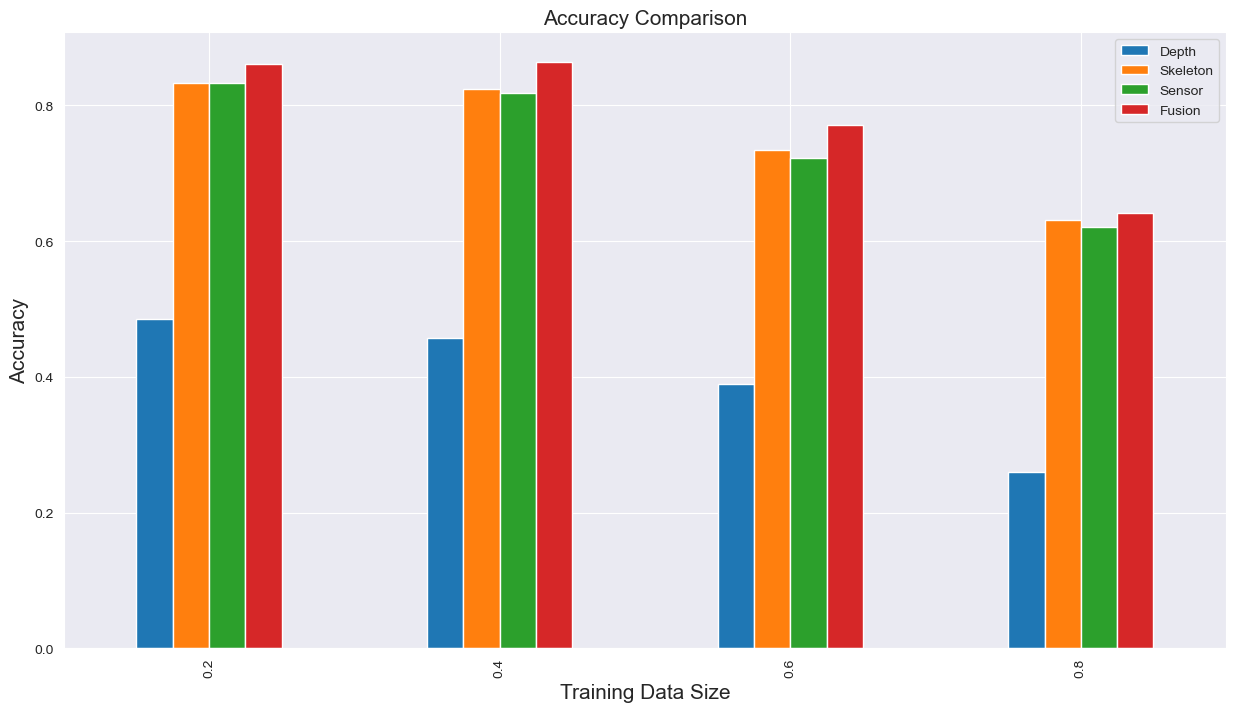

In [120]:
accdf = pd.DataFrame(accmat,columns=['Depth','Skeleton','Sensor','Fusion'],index=['0.2','0.4','0.6','0.8'])
accdf.plot(kind='bar',figsize=(15,8))
plt.xlabel('Training Data Size',fontsize=15)
plt.ylabel('Accuracy',fontsize=15)
plt.title('Accuracy Comparison',fontsize = 15)

Text(0.5, 1.0, 'Precision Comparison')

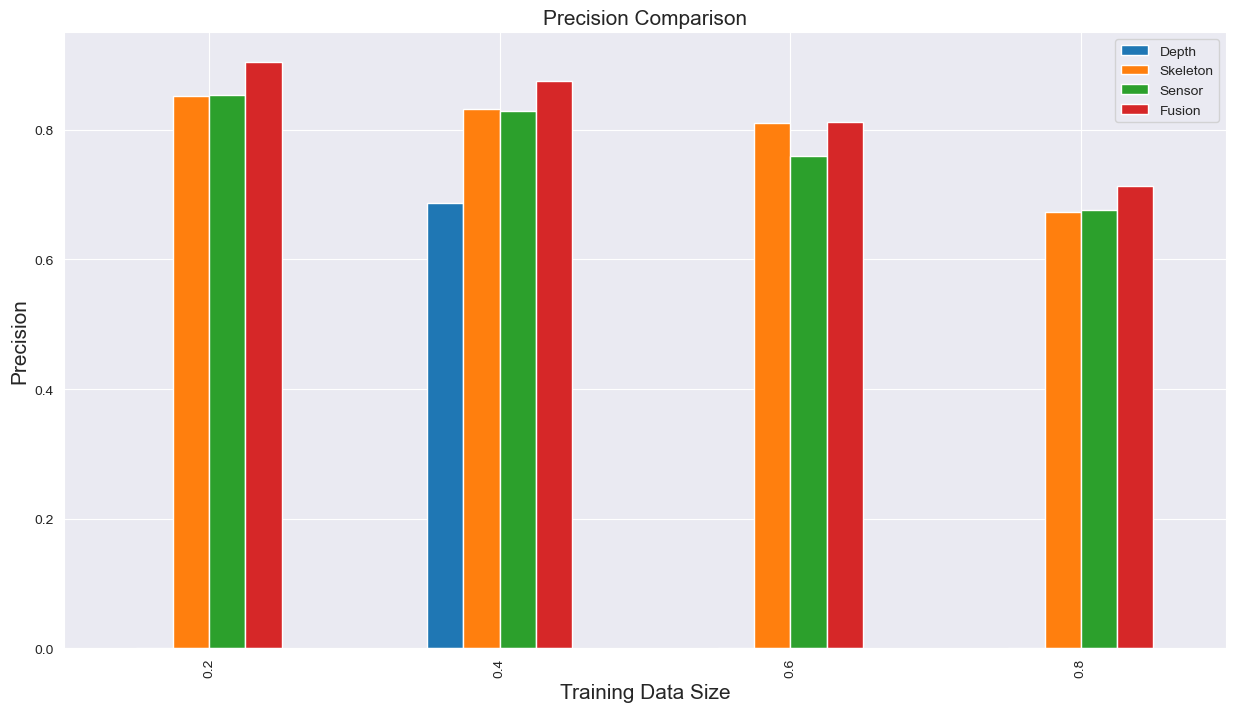

In [121]:
predf = pd.DataFrame(premat,columns=['Depth','Skeleton','Sensor','Fusion'],index=['0.2','0.4','0.6','0.8'])
predf.plot(kind='bar',figsize=(15,8))
plt.xlabel('Training Data Size',fontsize=15)
plt.ylabel('Precision',fontsize=15)
plt.title('Precision Comparison',fontsize = 15)

Text(0.5, 1.0, 'Recall Comparison')

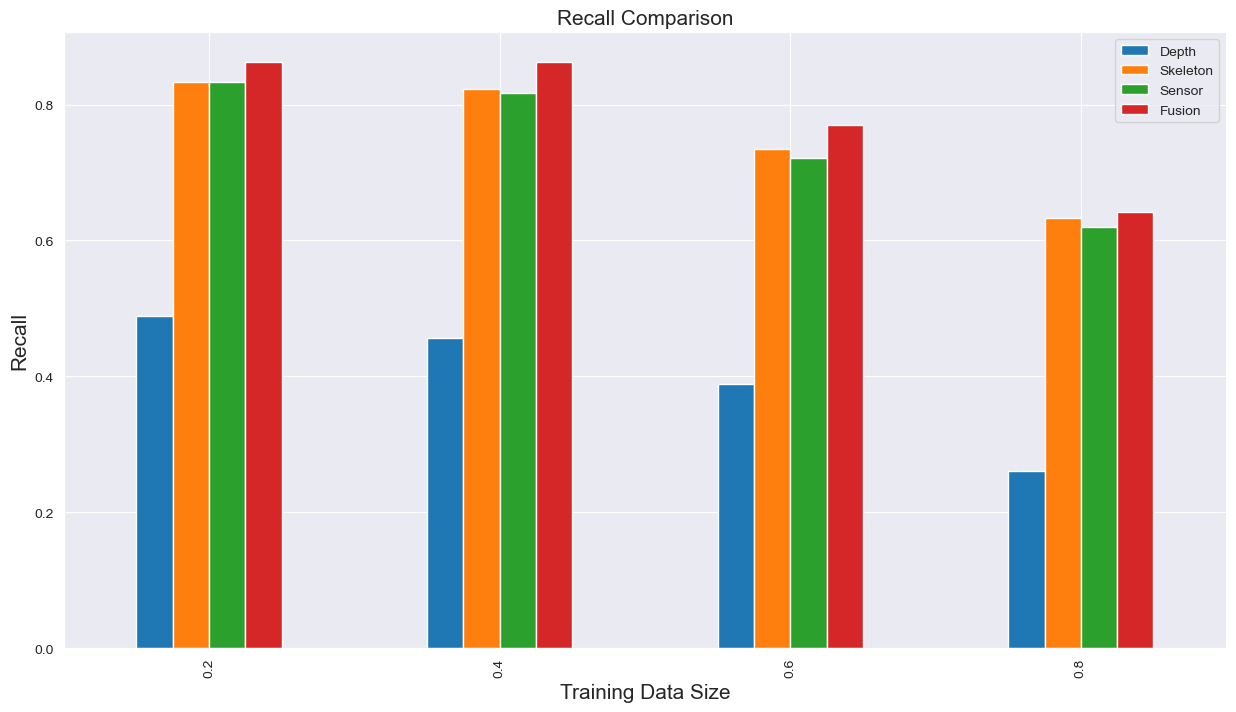

In [122]:
recdf = pd.DataFrame(recmat,columns=['Depth','Skeleton','Sensor','Fusion'],index=['0.2','0.4','0.6','0.8'])
recdf.plot(kind='bar',figsize=(15,8))
plt.xlabel('Training Data Size',fontsize=15)
plt.ylabel('Recall',fontsize=15)
plt.title('Recall Comparison',fontsize = 15)